In [1]:
from planning_through_contact.geometry.collision_geometry.box_2d import Box2d
from planning_through_contact.geometry.rigid_body import RigidBody
from planning_through_contact.planning.planar.planar_plan_config import ContactCostType, PlanarCostFunctionTerms, PlanarPlanConfig, SliderPusherSystemConfig
from planning_through_contact.geometry.collision_geometry.collision_geometry import ContactLocation, PolytopeContactLocation
from planning_through_contact.geometry.planar.face_contact import FaceContactMode
from planning_through_contact.geometry.planar.planar_pose import PlanarPose
from planning_through_contact.geometry.planar.planar_pushing_trajectory import PlanarPushingTrajectory
from planning_through_contact.geometry.planar.trajectory_builder import PlanarTrajectoryBuilder
from planning_through_contact.visualize.planar_pushing import visualize_planar_pushing_trajectory
from planning_through_contact.planning.planar.planar_plan_config import PlanarPushingStartAndGoal
from planning_through_contact.visualize.analysis import analyze_mode_result
from planning_through_contact.planning.planar.planar_plan_config import ContactCost
from planning_through_contact.planning.planar.planar_plan_config import ContactConfig

from pydrake.solvers import MosekSolver
from IPython.display import HTML, SVG, display

In [2]:
# Define slider
mass = 0.3
box_geometry = Box2d(width=0.3, height=0.3)
box = RigidBody("box", box_geometry, mass)

# Define pusher
pusher_radius = 0.05

# Define slider-pusher system
cfg = SliderPusherSystemConfig(
    slider=box,
    pusher_radius=pusher_radius,
    friction_coeff_slider_pusher=0.5,
    friction_coeff_table_slider=0.5,
    integration_constant=0.7
)

# Define cost
#contact_cost = ContactCost(
#    cost_type=ContactCostType.STANDARD,
#    arc_length=1.0,
#    force_regularization=0.1,
#    keypoint_velocity_regularization=None,
#    ang_velocity_regularization=1.0,
#    lin_velocity_regularization=1.0,
#    trace=None,
#)
contact_cost = ContactCost(
    cost_type=ContactCostType.STANDARD,
    keypoint_arc_length=None,
    linear_arc_length=0.1,
    angular_arc_length=0.05,
    force_regularization=0.1,
    keypoint_velocity_regularization=None,
    ang_velocity_regularization=1.0,
    lin_velocity_regularization=None,
    trace=None,
)
contact_config = ContactConfig(contact_cost)

plan_cfg = PlanarPlanConfig(
    dynamics_config=cfg, num_knot_points_contact=6, use_band_sparsity=True, contact_config=contact_config
)

In [3]:
def plan(contact_location, plan_cfg, initial_pose, final_pose):
    plan_cfg.contact_config.target_slider_pose = final_pose
    plan_cfg.start_and_goal = PlanarPushingStartAndGoal(initial_pose, final_pose)
    mode = FaceContactMode.create_from_plan_spec(contact_location, plan_cfg)
    mode.set_slider_initial_pose(initial_pose)
    mode.set_slider_final_pose(final_pose)

    mode.formulate_convex_relaxation()
    solver = MosekSolver()
    result = solver.Solve(mode.relaxed_prog)  # type: ignore
    assert result.is_success()

    vars = mode.variables.eval_result(result)
    traj = PlanarPushingTrajectory(plan_cfg, [vars])

    ani = visualize_planar_pushing_trajectory(traj, visualize_knot_points=True)
    return traj, mode, result, ani

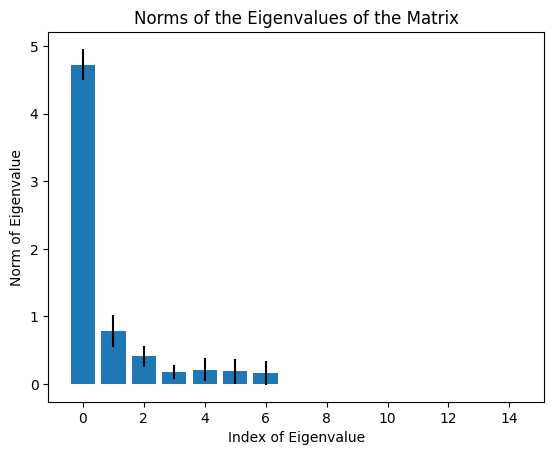

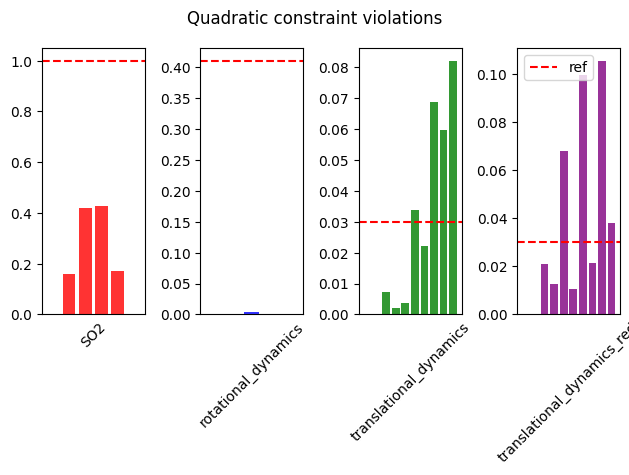

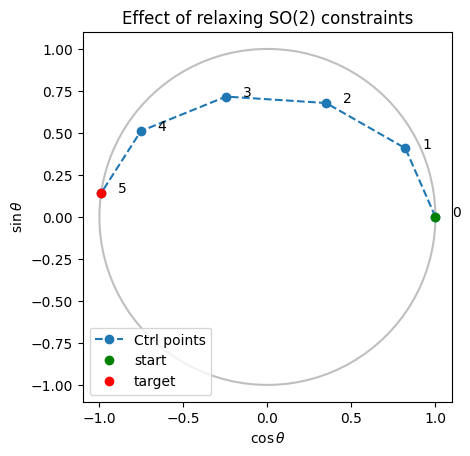

In [4]:
contact_location = PolytopeContactLocation(ContactLocation.FACE, 3)
initial_pose = PlanarPose(0, 0, 0)
final_pose = PlanarPose(0.3, 0.0, 3.0)
traj, mode, result, ani = plan(contact_location, plan_cfg, initial_pose, final_pose)

display(HTML(ani.to_jshtml()))
analyze_mode_result(mode, traj, result)